In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

In [3]:
# Packages
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint
import math
import pmdarima as pm

from utility_code.utility import utils

#import csvs
train = pd.read_csv("ucla2020-cs145-covid19-prediction/train.csv")
test = pd.read_csv("ucla2020-cs145-covid19-prediction/test.csv")
graph = pd.read_csv("ucla2020-cs145-covid19-prediction/graph.csv")
dummydata = pd.read_csv("data-test/raw_data_test.csv", skiprows=2, thousands=',')

train['Population'] = train['Confirmed'].divide(train['Incident_Rate'])*1e5
train['Active/Population'] = train['Active'].divide(train['Population'])
train['Deaths/Population'] = train['Deaths'].divide(train['Population'])
train['Active/People_Tested*Population'] = train['Active']/train['People_Tested']*train['Population']
train['Recovered/Population'] = train['Recovered']/train['Population']


confirmed = train['Confirmed'].to_list()
daily = [confirmed[i]-confirmed[i-50] for i in range(len(confirmed)) if i-50 >= 0]
for i in range(50):
    daily.insert(0,0)

train['New_Cases'] = daily

tests = train['People_Tested'].to_list()
dailyTests = [tests[i]-tests[i-50] for i in range(len(tests)) if i-50 >= 0]
for i in range(50):
    dailyTests.insert(0,0)

train['New_Tests'] = dailyTests

train['New_Cases/New_Tests'] = train['New_Cases']/train['New_Tests']

statesdata = {}
states = pd.Series.unique(train['Province_State'])
num_states = len(states)
for s in states:
    statesdata[s] = train.loc[train['Province_State'] == s ,:]

In [10]:
import pandas as pd
confirmed = statesdata['Wisconsin']['Confirmed']
deaths = statesdata['Wisconsin']['Deaths']
deaths = deaths.values
confirmed = confirmed.values
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return np.array(diff)


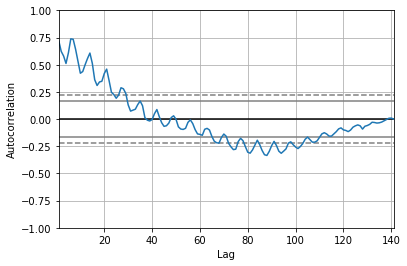

In [6]:
# Confirmed first order diff
conf = difference(confirmed, 1)
pd.plotting.autocorrelation_plot(conf)

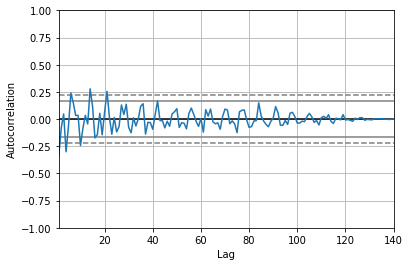

In [7]:
# Confirmed second order diff
conf = difference(difference(confirmed, 1), 1)
pd.plotting.autocorrelation_plot(conf)

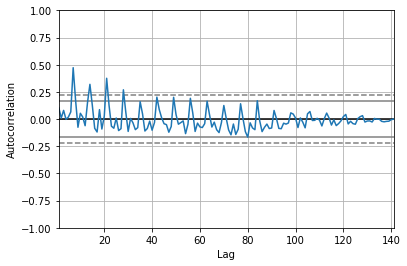

In [11]:
# Deaths first order diff
dd = difference(deaths,1)
pd.plotting.autocorrelation_plot(dd)

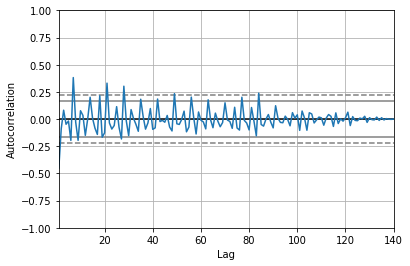

In [12]:
# Deaths first order diff
dd = difference(difference(deaths,1),1)
pd.plotting.autocorrelation_plot(dd)

In [16]:
days = 8 # our goal is to predict next 8 days

def predictARIMA(X, p, d, q, days):
    model = ARIMA(X, order=(p,d,q)) # initialize ARIMA model with order params
    model_fit = model.fit() # fit model to time series
    start = len(X) # starts with first day 
    forecast = model_fit.predict(start = start, end = start + days) # predict 26 days
    return(forecast) # return forecast as list

def predictARIMA_Validation(X, days, C = True):
    if C == True:
        arima = arima = pm.auto_arima(X, error_action='ignore', trace=True, max_p=3, max_d=2, max_q=2,
                                      suppress_warnings=True, maxiter=25, stepwise=False,
                                      seasonal= False, out_of_sample_size=10)
    else:
        arima = arima = pm.auto_arima(X, error_action='ignore', trace=True, max_p=9, max_d=2, max_q=7, start_p=5, start_q=4,
                                      suppress_warnings=True, maxiter=25, stepwise=False,
                                      seasonal= False, out_of_sample_size=10)
    forecast = arima.predict(n_periods = days)
    return(forecast)

def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    #yhat = np.exp(yhat)
    return yhat + history[-1]

true = {} # dictionary of data frames with true data for validation set
proj = {} # dictionary of data frames with projections for each state (key = state, value = df)
cp, cd, cq = 2,2,1
dp, dd, dq = 4,2,3
days = 10 
for s in states:
    
    validation_df = {}
    
    a = statesdata[s]
    a = a.reset_index()
    confirmed = a['Confirmed']
    validation_df['Confirmed'] = confirmed[-days:]
    confirmed = confirmed[:-days]
    deaths = a['Deaths']
    validation_df['Deaths'] = deaths[-days:]
    deaths = deaths[:-days]
    
    #run ARIMA on confirmed
    X = confirmed.values
    forecastC = predictARIMA(X, cp,cd,cq, days)
    
    #run ARIMA on deaths
    Y= deaths.values
    forecastD = predictARIMA(Y, dp,dd,dq, days)
    
    df = {'Confirmed': forecastC, 'Deaths': forecastD}
    true[s] = pd.DataFrame(validation_df)
    proj[s] = pd.DataFrame(df)

/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maxi

In [17]:
proj['Alabama']

,Confirmed,Deaths
0,114704.474171,2013.303619
1,115783.848985,2025.439551
2,116857.452494,2035.115060
3,117931.187469,2047.443207
4,119004.611277,2061.895013
5,120078.028966,2079.037636
6,121151.429313,2096.307265
7,122224.828581,2112.814816
8,123298.226850,2127.969174
9,124371.625017,2142.265159


In [18]:
true['Alabama']

,Confirmed,Deaths
132,114532,2011
133,115060,2013
134,116710,2024
135,117242,2037
136,119254,2045
137,121023,2076
138,122185,2107
139,123889,2152
140,125235,2162
141,126058,2182
